![title](img/Servier_Logo.png)

# Прогноз третичных опродаж

## Создать модель ML прогнозирующую третичные продажи (от Servier)
* в разрезе общего числа продаж каждой формы препарата по определенной аптечной точке
* с прогнозом на контретный календарный месяц
* с периодом прогноза 3 месяца

# Импорт библиотек

In [166]:
#pip install sktime
#pip install tbats
#pip install statsforecast
#pip install pyodbc
import pandas as pd
import pyodbc
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from sklearn import linear_model

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS

from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter

from sklearn.model_selection import GridSearchCV

from sktime.performance_metrics.forecasting import MeanSquaredError

from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.all import mean_squared_error
from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)
from sktime.forecasting.compose import EnsembleForecaster
# установка единого размера шрифта:
plt.rcParams.update({'font.size': 8})
sns.set (font_scale= 0.75)

* 2018.csv                   - продажы 2018
* 2019.csv                   - продажы 2019
* 2020.csv                   - продажы 2020
* 2021.csv                   - продажы 2021
* 2022.csv                   - продажы 2022
* 2023.csv                   - продажы 2023
* sku.csv                    - список форм препарата датасет
* df_test.csv                - тестовый датасет
* df_pred.csv                - датасет прогноза
* pharmacy_sales_fact_q1.csv - фактические продажи за первый квартал 2024 года

# Для простой модели прогнозирования вторичных продаж отлично подходит библиотека ![title](img/sktime_logo.PNG)
* документация к ней [здесь](https://www.sktime.net/en/stable/user_guide.html)

# Датасеты по годам (соединение в 1 датасет)
**данные по объему продаж за 6 лет**
* первичный анализ данных
* найти пропуски (в исходных нет)
* найти выбросы (таковые имеются Ковид, СВО)
* выявить сезонность (в выбранном подходе библиотеке Sktime реализован)

In [188]:
df_2018=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2018\2018.csv", sep=";")
df_2019=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2019\2019.csv", sep=";")
df_2020=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2020\2020.csv", sep=";")
df_2021=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2021\2021.csv", sep=";")
df_2022=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2022\2022.csv", sep=";")
df_2023=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\2023\2023_new.csv", sep=";")
df_2023 = df_2023.rename(columns={'cnt':'(No column name)'})
df_2023.sku_code_ru=df_2023.sku_code_ru.str.strip('{}')
df = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df_name=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\sku.csv", sep="\t")
df_name = df_name[['Guid', 'Name']]
df_name.columns = ['sku_code_ru', 'Name']
name_list = df_name.Name.unique()
df = df.merge(df_name, on='sku_code_ru', how='left')
df = df.rename(columns={'(No column name)': 'Tertiary_Sales'})
df = df.dropna()
df = df.drop('sku_code_ru', axis= 1 , inplace= True )
df = df[['period_ru', 'aptId_ru', 'Name', 'Tertiary_Sales']]
df['Tertiary_Sales']=df['Tertiary_Sales'].str.replace(',','.')
df['Tertiary_Sales'] = df['Tertiary_Sales'].astype (str).astype (float) # перобразование целевого признака на числовой
df['period_ru'] = pd.to_datetime(df['period_ru']).dt.to_period('M')
df.set_index(df['period_ru'], inplace=True) # перенос даты в индекс (создание временного ряда)
df = df.drop(['period_ru'], axis=1)
df = df.sort_values(by='period_ru')
df


,aptId_ru,Name,Tertiary_Sales
period_ru,,,
2018-10,229201,NaN,1.0
2018-10,159663,"TRIP 5/1,25/5",1.0
2018-10,181713,PRED OD 60,1.0
2018-10,105460,NaN,2.0
2018-10,141484,DETR 1000 30,2.0
...,...,...,...
2023-12,330850,DETR,1.0
2023-12,136765,DETR 1000 60,2.0
2023-12,429166,PRED OD 60,3.0


# Описание датасета

* period_ru              - дата (временной ряд) индекс
* aptId                  - ID аптеки
* Name                   - имя формы ЛП
* Tertiary_Sales         - кол-во проданных упаковок **(целевой признак)**

Странно, но целевой признак содержит дробные значения тогда когда должно быть целочисленным, так как нельзя купить 1,5 упаковки.
Переведу в численный формат, проверю сколько таких значений и округлю до целых (возможно посчитаю выбросами, если таковых значений будет немного)

# Фактические продажи (приведение к общемы виду датасета)

In [187]:
df_fact=pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Tertiary sales\data\pharmacy_sales_fact_q1.csv", sep=";")
df_fact = df_fact.rename(columns={'cnt': 'Tertiary_Sales'})
df_fact = df_fact.merge(df_name, on='sku_code_ru', how='left')
df_fact.dropna()
df_fact.drop('sku_code_ru', axis= 1 , inplace= True )
df_fact = df_fact[['period_ru', 'aptId_ru', 'Name', 'Tertiary_Sales']]
df_fact['Tertiary_Sales']=df_fact['Tertiary_Sales'].str.replace(',','.')
df_fact['Tertiary_Sales'] = df_fact['Tertiary_Sales'].astype (str).astype (float) # перобразование целевого признака на числовой
df_fact['period_ru'] = pd.to_datetime(df_fact['period_ru']).dt.to_period('M')
df_fact.set_index(df_fact['period_ru'], inplace=True) # перенос даты в индекс (создание временного ряда)
df_fact = df_fact.drop(['period_ru'], axis=1)
df_fact = df_fact.sort_values(by='period_ru')
df_fact

,aptId_ru,Name,Tertiary_Sales
period_ru,,,
2024-01,181987,PRES 5,5.0
2024-01,988591,DIAB MB 60,1.0
2024-01,920536,NOLIP A FORTE,1.0
2024-01,933036,PRNC 10/5,1.0
2024-01,149696,DETR 1000 60,1.0
...,...,...,...
2024-03,142253,PRES 10,3.0
2024-03,574849,DETR,3.0
2024-03,970351,PRON,4.0


## Обработка данных
### Статистические показатели данных датасета
*заметим что  в стат данных присутствуют отрицательные значения - разберемся ниже*

In [ ]:
df.describe()

,aptId_ru,Tertiary_Sales
count,3.470858e+07,3.470858e+07
mean,2.268660e+05,4.077816e+00
std,1.404634e+05,9.231565e+00
min,1.300000e+02,-4.000000e+00
25%,1.439860e+05,1.000000e+00
50%,1.891170e+05,2.000000e+00
75%,2.386150e+05,4.000000e+00
max,1.110000e+06,8.277000e+03


### Данные по отрицательным значениям в датасете 
*необходимо понять, это были возвраты по продажам!!!!
так же понять и решить как с ними поступить:*
* в случае возвратов - оставить так как есть (важна причина - возможно выявить признак и если он отражен в плане продаж, то можно его использовать в прогнозе)
* в случае ошибки в базе - проверить и поправить (скорее всего убрать знак "-")

In [189]:
df.loc[df['Tertiary_Sales'] < 0 ] # показанны данные по 1 аптеке в малом количестве
df_n = df[df['aptId_ru'] == 384394]
df[df.select_dtypes(include=[np.number]).ge(0.0).all(1)] #убрал отрицательные значения (пока просто удалил, так как их мало)

,aptId_ru,Name,Tertiary_Sales
period_ru,,,
2018-10,229201,NaN,1.0
2018-10,159663,"TRIP 5/1,25/5",1.0
2018-10,181713,PRED OD 60,1.0
2018-10,105460,NaN,2.0
2018-10,141484,DETR 1000 30,2.0
...,...,...,...
2023-12,330850,DETR,1.0
2023-12,136765,DETR 1000 60,2.0
2023-12,429166,PRED OD 60,3.0


# Поменяю структуру датасета
**вычислю атуальные аптечные точки на 2023-10**

In [190]:
df_1 = df.drop(['Name'], axis=1)
df_1 = df_1.pivot_table(values='Tertiary_Sales', index=df.index,
                     columns='aptId_ru', aggfunc='first')
df_1 = df_1.tail(1)
df_1=df_1.dropna(axis=1,how='all')
list_ap = df_1.columns.values.tolist () # список аптечных точек, актуальных на 2023-10
df_actual = df.loc[df['aptId_ru']. isin(list_ap)]
df_actual = df_actual.sort_index()
df = df_actual
df_c = df.aptId_ru.unique() # количество актуальных аптечных точек на 2023-10 = 44759 штук

# Топ 3 форм ЛП можно посмотреть на печеньке ниже

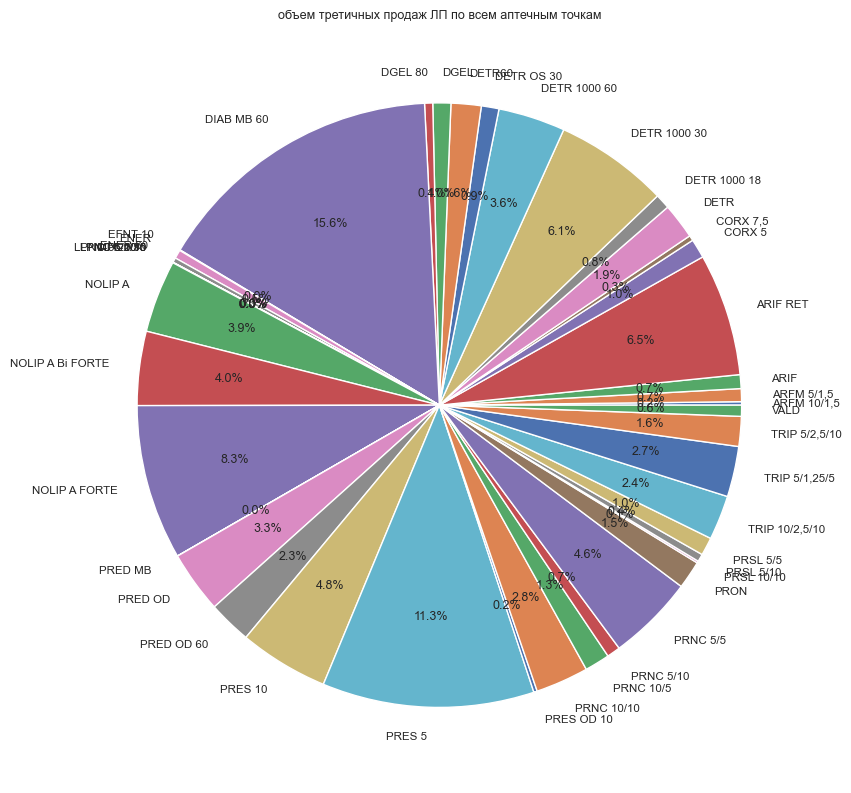

In [191]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (12,8))

sales = df.groupby(by='Name').sum()['Tertiary_Sales']

ax.set_title('объем третичных продаж ЛП по всем аптечным точкам')
ax.pie(x=sales, autopct="%.1f%%", labels=sales.index, pctdistance=0.7)

plt.tight_layout()
plt.show()

# ТОП 3 аптечных точек по количеству продаж форм ЛП:
* 217938     97713.00
* 127918    107468.17
* 116157    122540.00

In [192]:
sales_2 = df.groupby(by='aptId_ru').sum()['Tertiary_Sales']
sales_2.sort_values(axis=0)

aptId_ru
986839         1.00
987226         1.00
976865         1.00
976871         1.00
976872         1.00
            ...    
127906     82099.33
122606     84630.00
217938     99861.00
127918    109734.17
116157    125629.00
Name: Tertiary_Sales, Length: 44759, dtype: float64

## на будущее, запрошу у пользователя номер аптечной точки и имя формы ЛП

In [193]:
'''ТОП 3 аптечных точек по количеству продаж форм ЛП:**
* 217938     97713.00
* 127918    107468.17
* 116157    122540.00'''

def apt_id_chuse():
    while True:
        try:
            num = int(input("Введите ID аптечной точки: "))
            return num
        except ValueError:
            print("Вы ввели не число. Повторите ввод")


apt_number = apt_id_chuse()

'''ТОП 3 аптечных точек по количеству продаж форм ЛП:**
* DIAB MB 60
* ARIF RET
* NOLIP A FORTE'''

lp_name = input("Введите имя формы ЛП: ")

if lp_name == set(name_list):
    print("Отлично!")
else:
    print("Такой формы препарата нет в списке!")

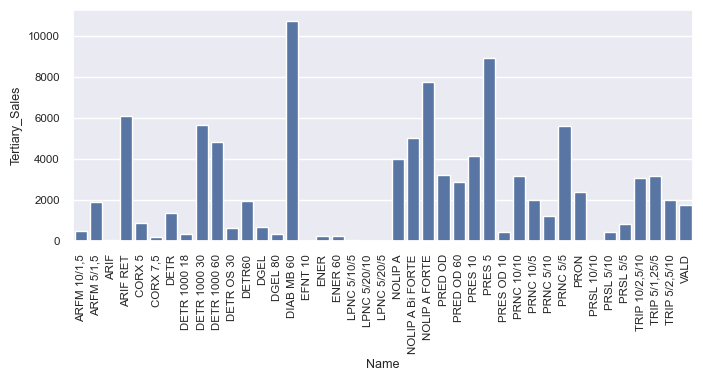

In [194]:
df_n = df[df['aptId_ru'] == apt_number] # смотрим график продаж одной аптеки за все время по всем формам ЛП

plt.figure(figsize=(8,3))
sns.barplot(data=df_n.groupby(by='Name').sum().reset_index(), x="Name", y='Tertiary_Sales')
plt.xticks(rotation=90)
plt.show()

# Попробую изменить стуктуру данных

In [195]:
df_n = df_n.pivot_table(values='Tertiary_Sales', index=df_n.index,
                     columns='Name', aggfunc='first')

<Axes: xlabel='period_ru'>

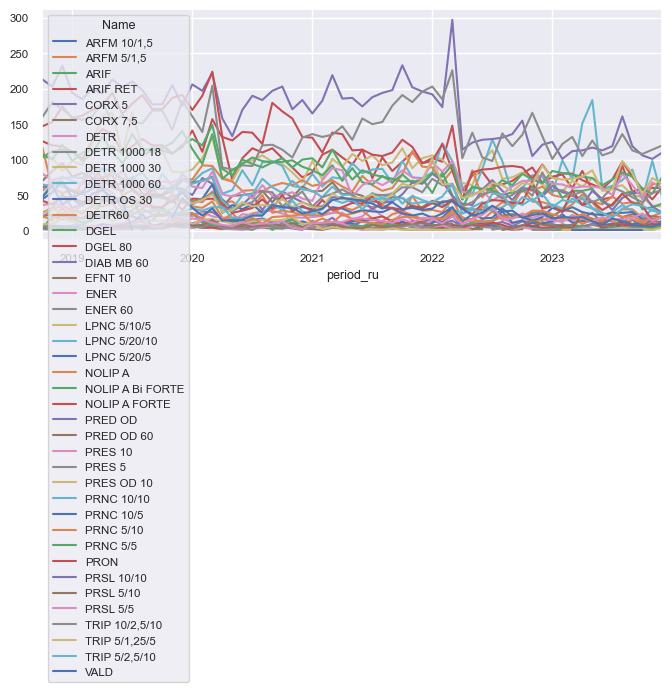

In [196]:
df_n.plot(figsize=(8,3))

**на общем графике по прежнему недостаточно информации, нужно смотреть каждую форму препарата в отдельности. Попробую разбить ниже результат.**

array([<Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='period_ru'>,
       <Axes: xlabel='period_ru'>, <Axes: xlabel='perio

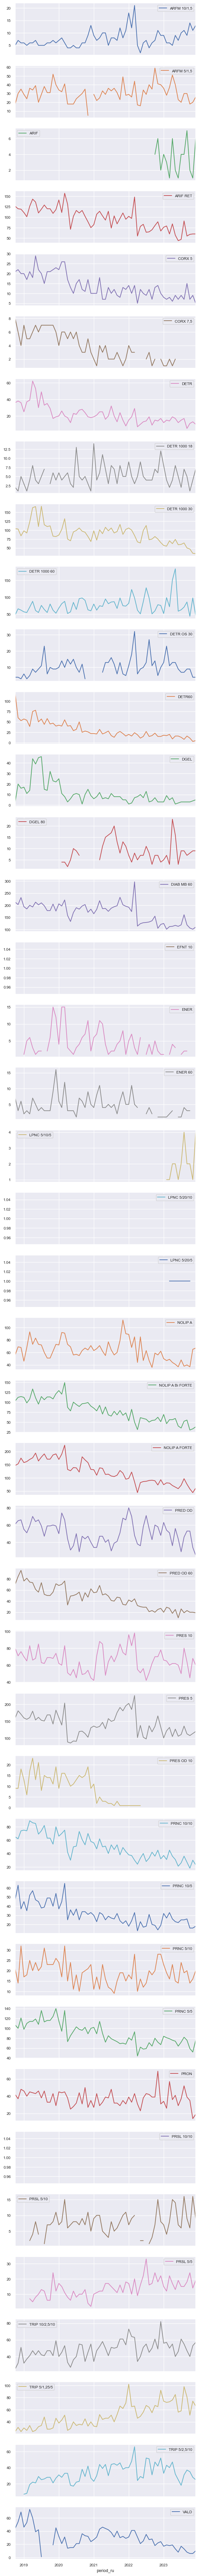

In [197]:
df_n.plot(subplots=True, figsize=(7, 100))

**как видно из графиков в датасете отсутствуют ЛП снятые с продаж, но видны позиции по которым закупки вообще не производились, оставляем их в сете, так как список форм ЛП актуален а это значит что могут возникнуть по ним заказы. Только  прогноз для новых форм ЛП будет расчитываться иначе на основании среднего значения прямого его конкурента, наиболее подходящего по объему закупок других форм ЛП**

**С учетом увиденного и выводами выше оставляю структуру данных дата сета этой аптеки только по актуальным формам ЛП В дальнейшем можно сопоставить названия форм препарата из вторичных продаж и оставить список стандартным для всех аптек**

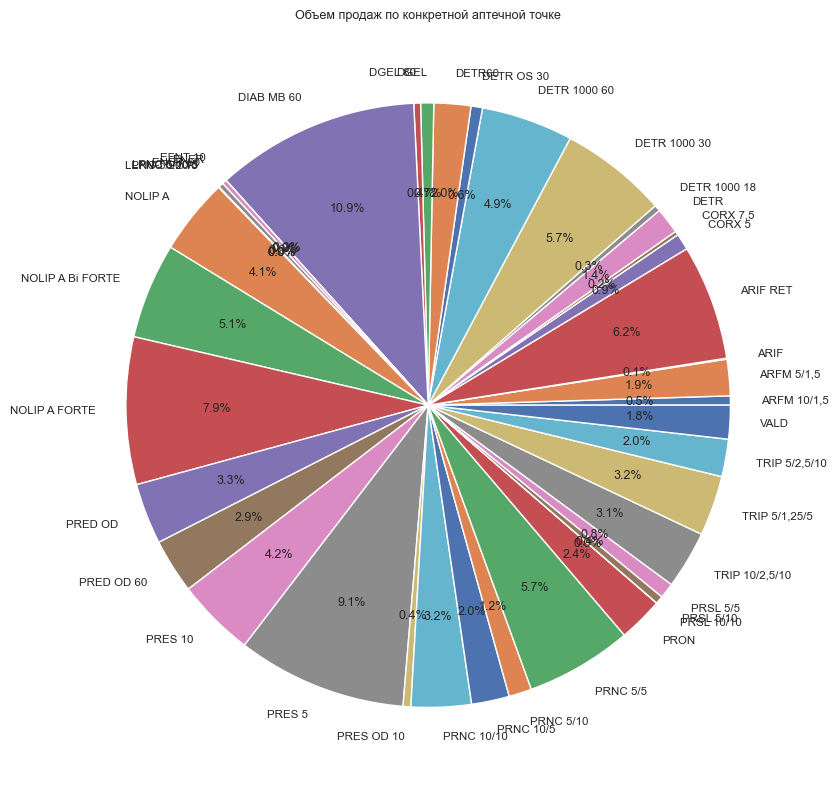

In [198]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (12,8))

sales = df[df['aptId_ru'] == apt_number].groupby(by='Name').sum()['Tertiary_Sales']

ax.set_title('Объем продаж по конкретной аптечной точке')
ax.pie(x=sales, autopct="%.1f%%", labels=sales.index, pctdistance=0.7)

plt.tight_layout()
plt.show()

## так же проверяю данные в разрезе одного препарата, что бы лучше понять характер изменения продаж.

<Axes: xlabel='period_ru'>

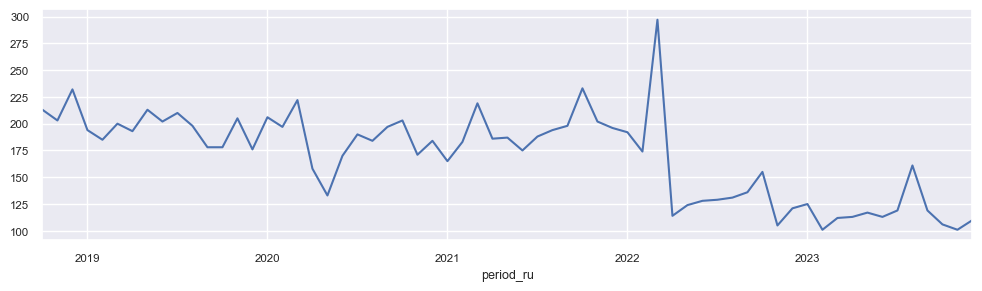

In [199]:
df.loc[(df['aptId_ru'] == apt_number) &(df['Name'] == lp_name)].Tertiary_Sales.plot(figsize=(12,3))

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tertiary_Sales'>)

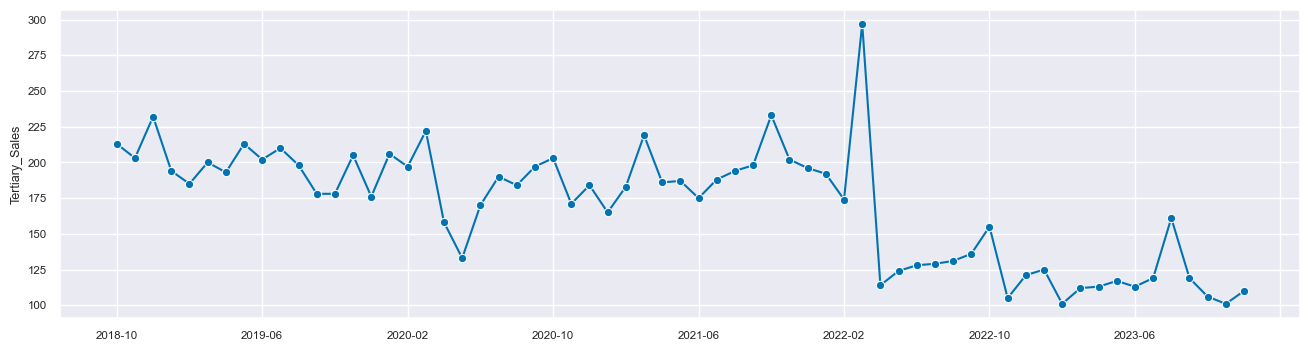

In [200]:
plot_series(df.loc[(df['aptId_ru'] == apt_number) &(df['Name'] == lp_name)].Tertiary_Sales)

# Период прогноза
* принимаем на периоде абсолютные даты, конкретные месяцы

In [201]:
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2024-01", periods=3, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2024-01', '2024-02', '2024-03'], dtype='period[M]', is_relative=False)

## Обучение и валидация модели
* деление датасета тренинговый и тестовый датасет 

## Разделил на тренинговый датасет и тестовый, для того  что бы проверить модель на точность.

(50, 13)

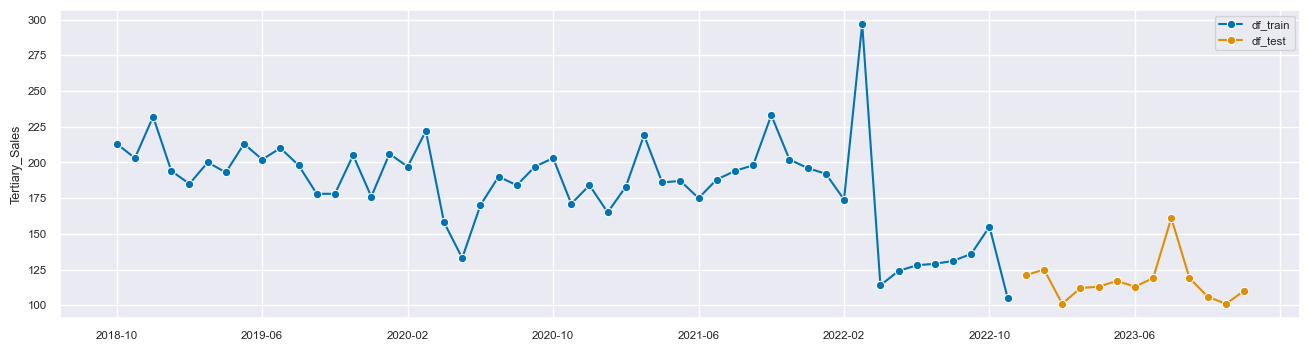

In [202]:
df_train, df_test = temporal_train_test_split(df.loc[(df['aptId_ru'] == apt_number) &(df['Name'] == lp_name)].Tertiary_Sales, test_size=0.2)
plot_series(df_train, df_test, labels=["df_train", "df_test"])
(df_train.shape[0], df_test.shape[0])

# Выбросы (скользящее сглаживание выберем предыдущее окно в 3 месяца)
* делаем прогнозы для тестового датасета от тренингового, для этого горизонт прогноза основываем на тестовых данных

(48, 13)

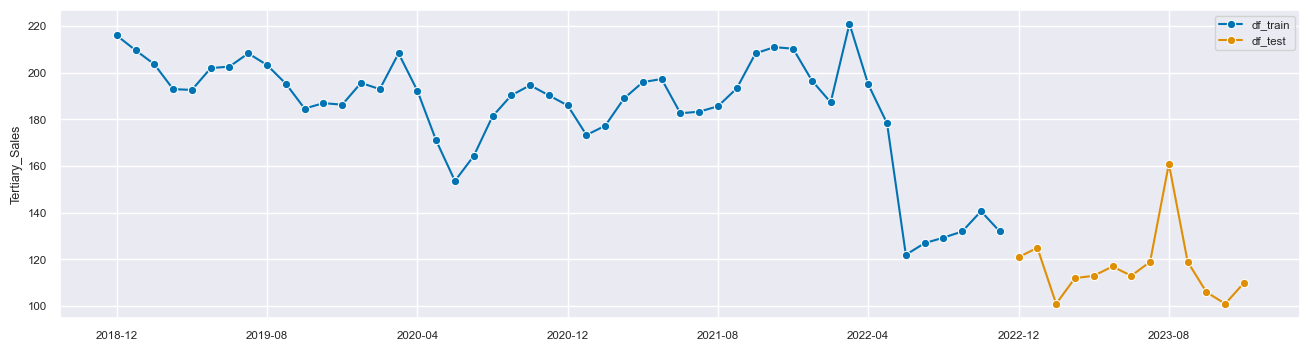

In [203]:
df_train = df_train.rolling(window=3).mean()
df_train = df_train.dropna()
plot_series(df_train, df_test, labels=["df_train", "df_test"])
(df_train.shape[0], df_test.shape[0])

## Алгоритм прогнозирования
## (модель экпоненциальное сглаживание)
*взаимодействует с рядом алгоритмов статистического прогнозирования statsmodels: exponential smoothing (экспоненциальное сглаживание), theta и auto-ETS*

### 1 метод ExponentialSmoothing

0.10054858611428186

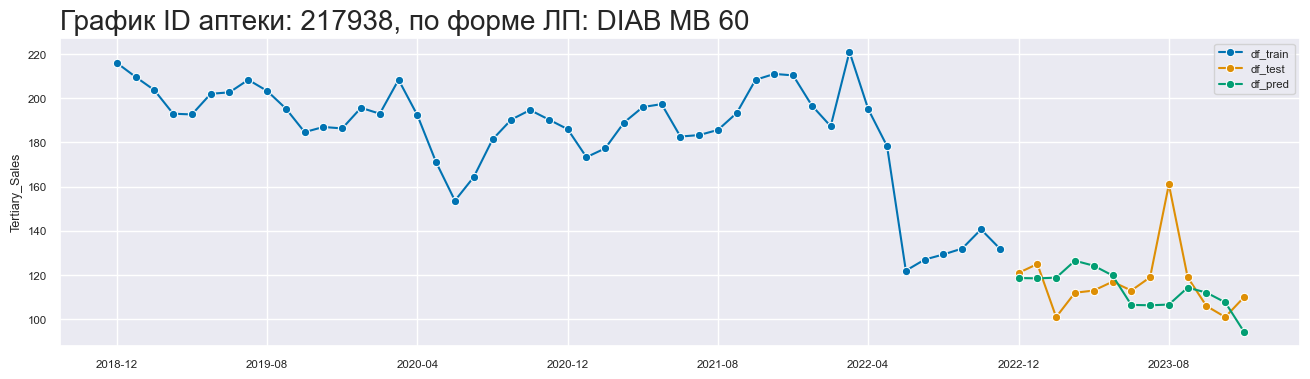

In [204]:
# 1 метод ExponentialSmoothing
fh_t = ForecastingHorizon(df_test.index, is_relative=False)

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=6)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

# Оценка модели на тестевом датасете
*напоминаю в срезе одной формы ЛП, для наглядного примера*
* метрика прогноза. Чем меньше тем лучше (зависит от качества подготовленных данных а так же полезно сравнивать данный показатель с показателями конкурентов при том же алгоритме)

In [205]:
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

0.10054858611428186

In [206]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape(df_test, df_pred)

0.10054858611428186

In [207]:
forecaster.get_fitted_params()

{'initial_level': 222.5038350645894,
 'initial_slope': None,
 'initial_seasons': array([-4.45543331, -2.59873793, -0.24605286,  9.44946166,  9.22429983,
         6.84001964]),
 'aic': 259.737653321823,
 'bic': 278.4496634309019,
 'aicc': 268.65193903610873}

### 2 метод AutoETS

0.1729086021851368

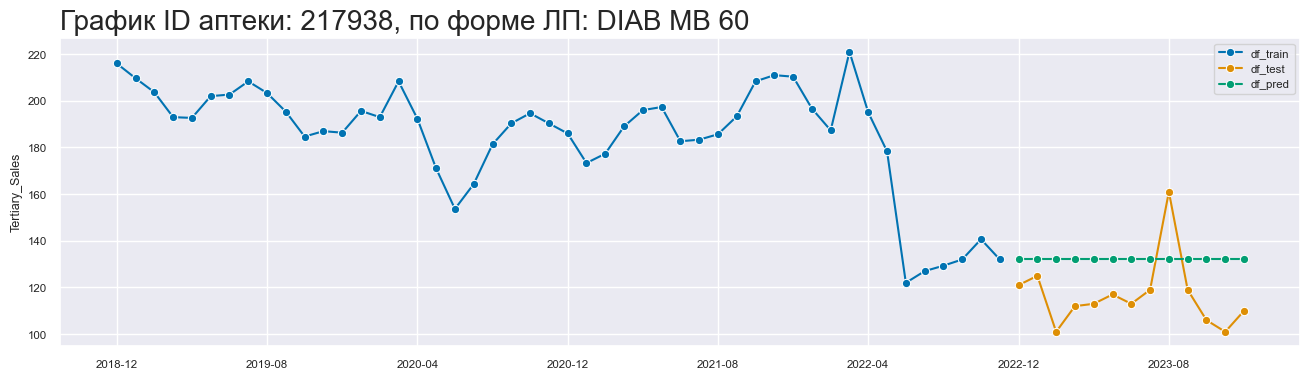

In [208]:
# 2 метод AutoETS
forecaster = AutoETS(auto=True, sp=2, n_jobs=-1)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### 3 метод ARIMA

0.13772269286238492

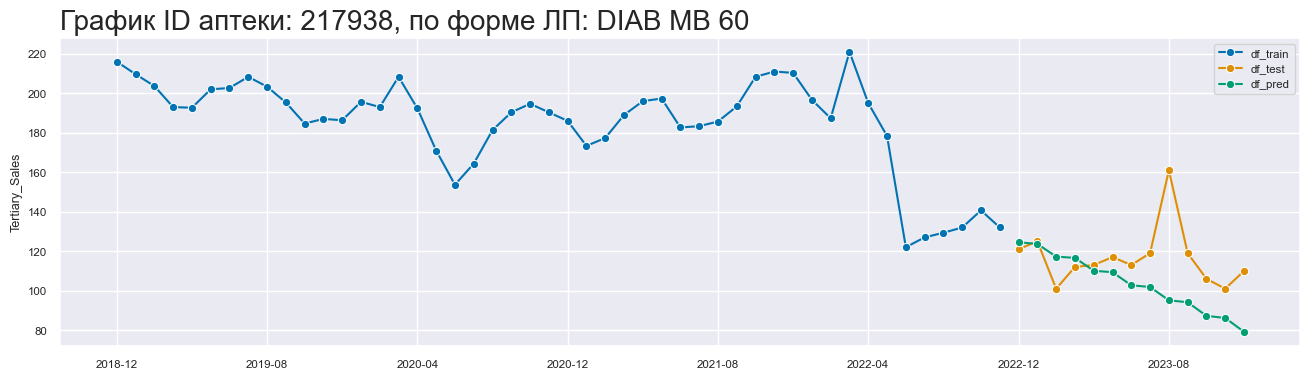

In [209]:
# 3 метод ARIMA
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(1, 1, 1, 2), suppress_warnings=True
)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### AutoARIMA

0.17290191208410477

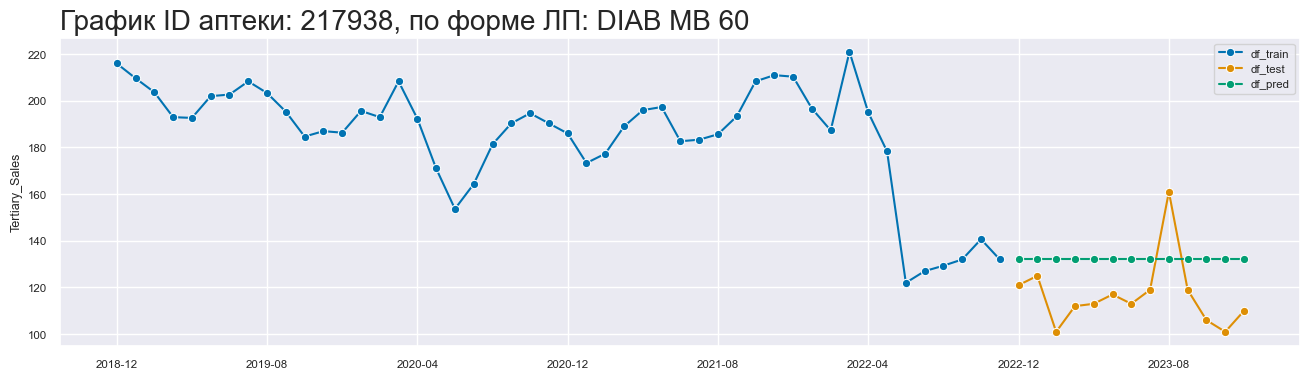

In [210]:
# AutoARIMA
forecaster = AutoARIMA(sp=1, suppress_warnings=True)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### 4 метод BATS

0.13347706311479748

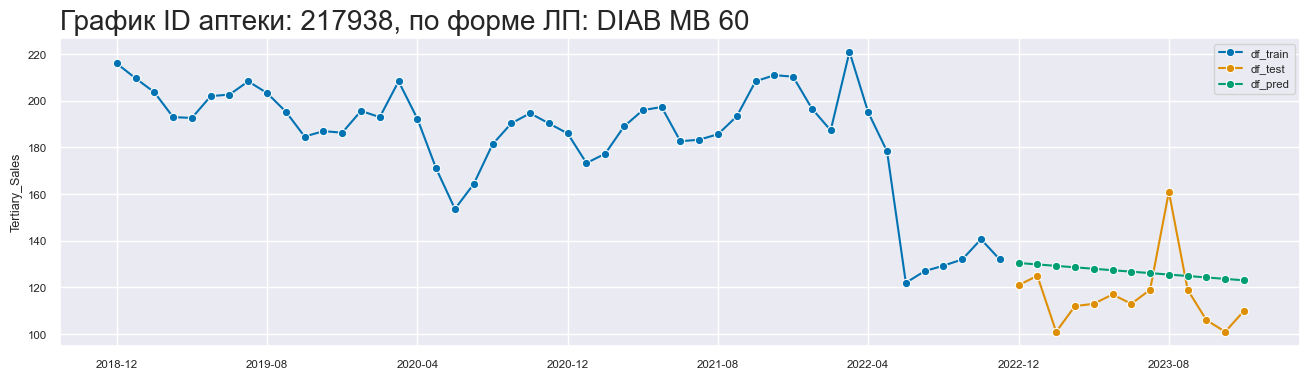

In [211]:
# 4 метод BATS
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### TBATS

0.13347706311479748

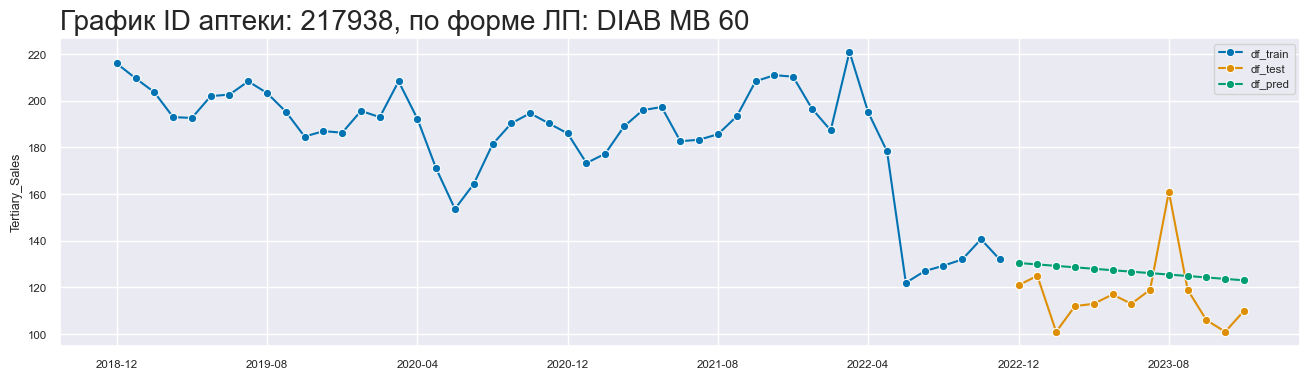

In [212]:
# TBATS
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### 5 метод StatsForecastAutoARIMA

0.14918414918414918

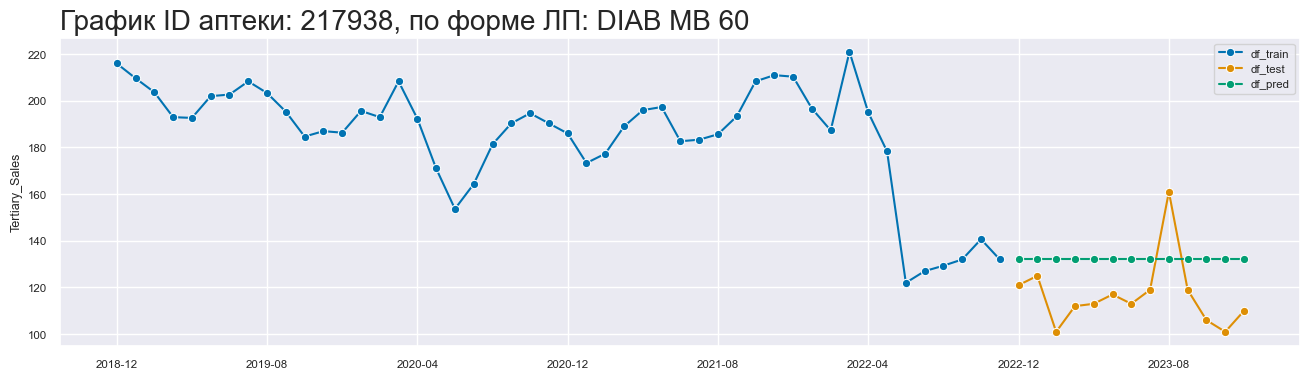

In [213]:
# 5 метод StatsForecastAutoARIMA
forecaster = StatsForecastAutoARIMA(sp=1)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_pred, df_test)

![title](img/fit.png)

## Расширенные шаблоны композиции - pipelines, reduction, autoML
* Reduction — построение прогнозиста из оценок «более простых» научных типов, таких как scikit-learnрегрессоры. Типичным примером является табуляция объектов/меток с помощью прокручивающегося окна, также известная как «стратегия прямого сокращения».

* Tuning — определение значений гиперпараметров прогнозиста на основе данных. Типичным примером является поиск по сетке при временной повторной выборке разделений поезда/теста.

* Pipelining — объединение преобразователей с прогнозистом для получения одного прогнозиста. Типичным примером является устранение тренда и десезонализация, а затем прогнозирование, примером этого является обычный «прогнозист STL».

* AutoML, также известный как автоматический выбор модели, — использование стратегий автоматической настройки для выбора не только гиперпараметров, но и целых стратегий прогнозирования. Типичным примером является онлайн-настройка мультиплексора.

### 6 метод make_reduction

0.5470986485747614

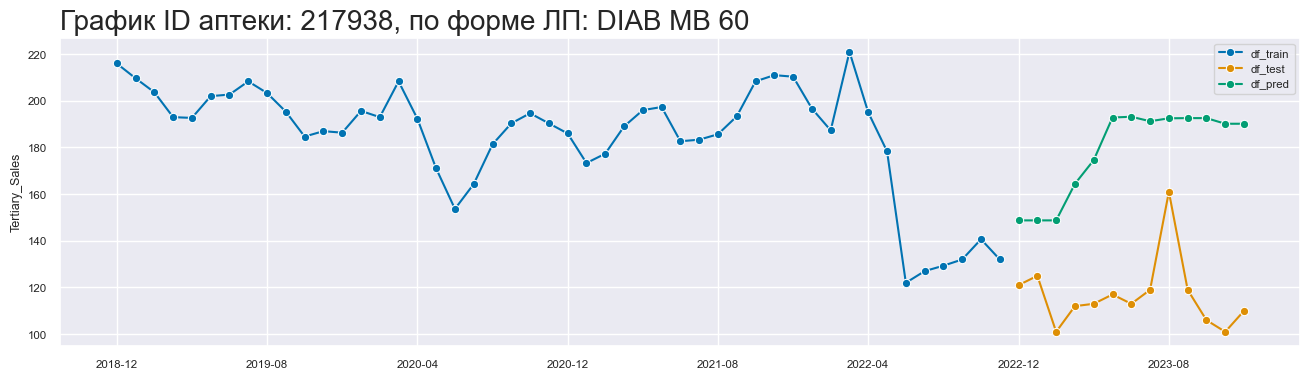

In [214]:
# 6 метод make_reduction
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=4, strategy="recursive")

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

In [215]:
forecaster.get_params()

{'estimator': KNeighborsRegressor(n_neighbors=4),
 'pooling': 'local',
 'transformers': None,
 'window_length': 4,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 4,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

### 7 метод The basic forecasting pipeline

0.4484465321664579

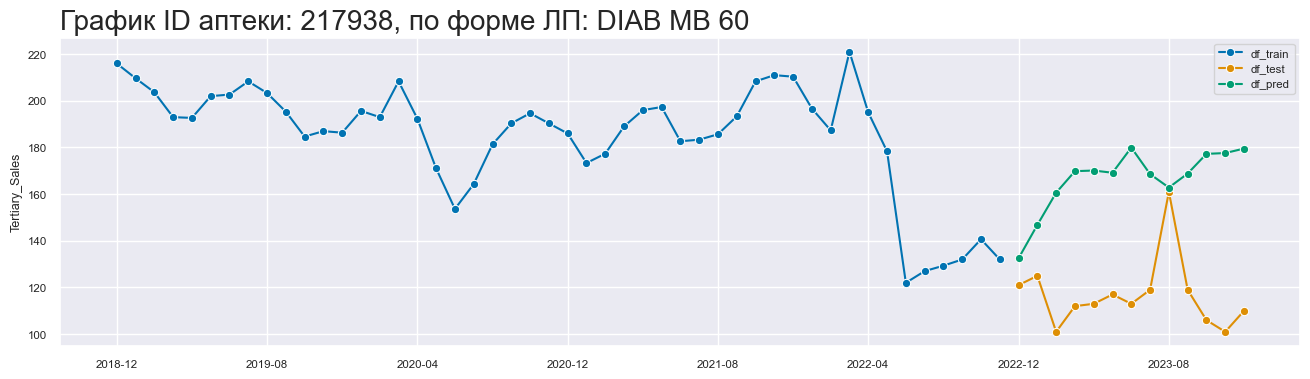

In [216]:
# 7 метод The basic forecasting pipeline
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=15)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

*множественная сезонность*

0.4232064398331393

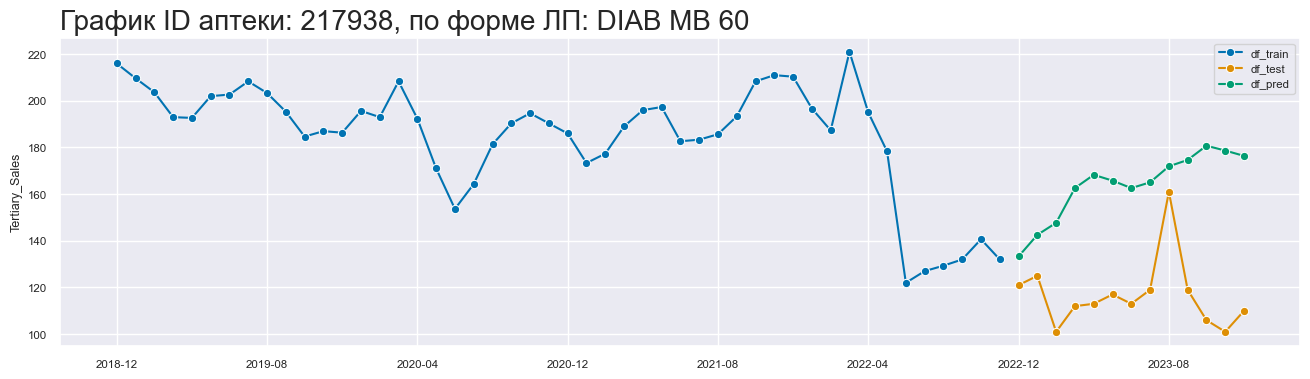

In [217]:
# 7 метод The basic forecasting pipeline  (множественная сезонность)
forecaster = (
    Deseasonalizer(model="multiplicative", sp=6)
    * Deseasonalizer(model="multiplicative", sp=18)
    * ARIMA()
)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### 8 метод The Detrender as pipeline component
*попробовать убрать тренд и посмотреть как поменяются значения продаж*

Text(0.0, 1.0, 'Графики ID аптеки: 217938, по форме ЛП: DIAB MB 60')

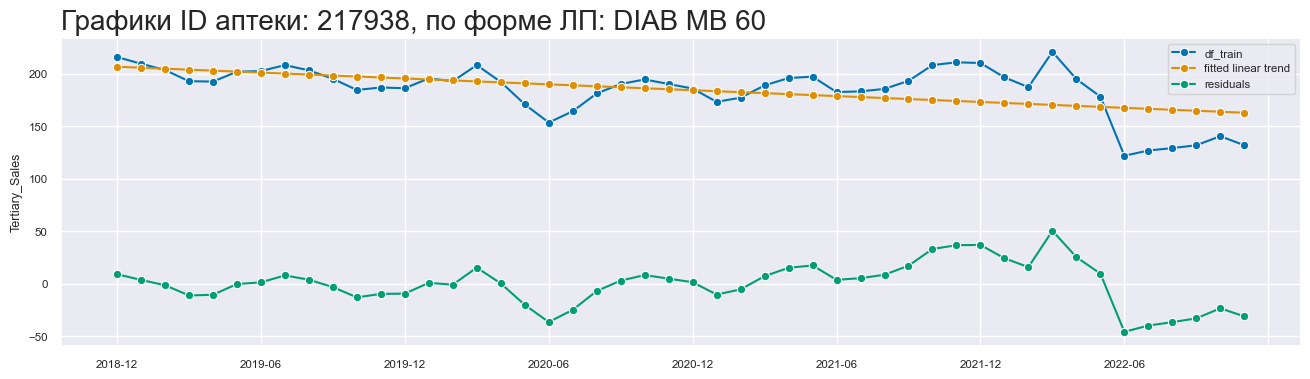

In [218]:
# посмотрим линию тренда
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(df_train)

forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(df_train))
df_pred = forecaster.fit(df_train).predict(fh=fh_ins)

plot_series(df_train, df_pred, yt, labels=["df_train", "fitted linear trend", "residuals"])
plt.title('Графики ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')

0.27373349461115104

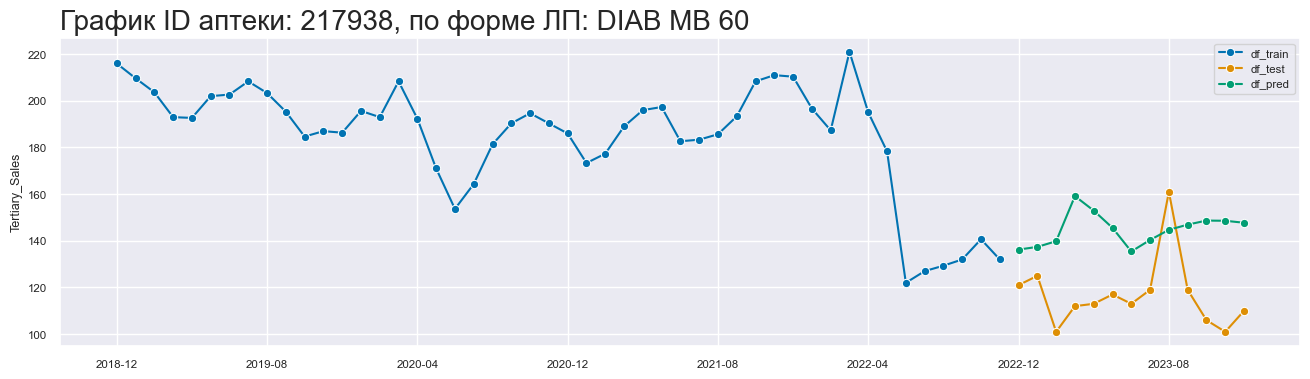

In [219]:
# 8 метод The Detrender as pipeline component
#попробовать убрать тренд и посмотреть как поменяются значения продаж
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

### 9 метод Complex pipeline composites and parameter inspection

0.3843083684813431

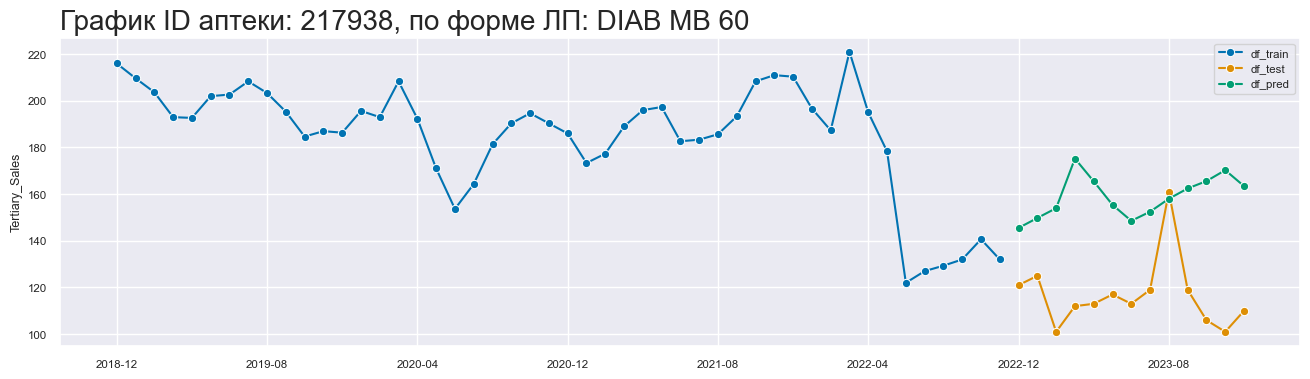

In [220]:
# 9 метод Complex pipeline composites and parameter inspection
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(df_train)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

In [221]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=15))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=15),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'detrend__model': 'additive',
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'forecast__estimator': KNeighborsRegressor(),
 'forecast__pooling': 'local',
 'forecast__transformers': None,
 'forecast__window_length': 15,
 'forecast__estimator_

0.6163588167999335

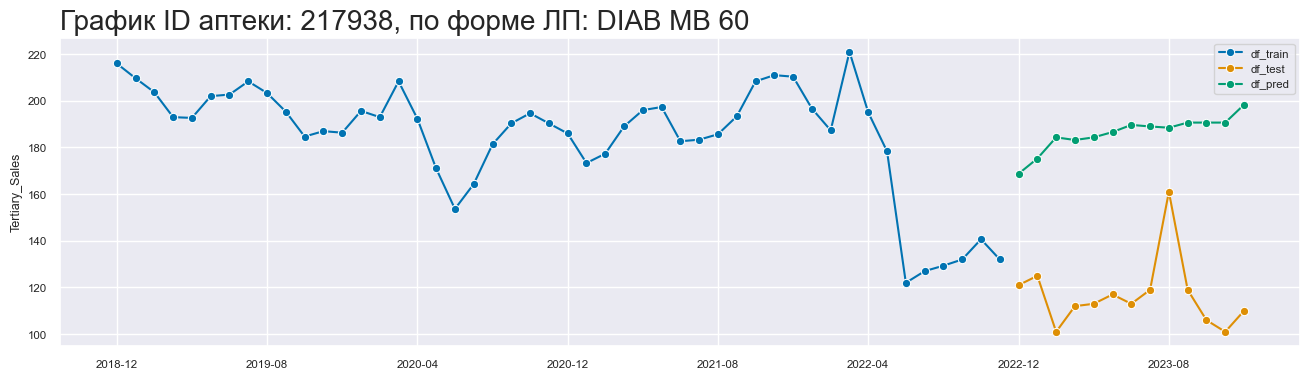

In [222]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# Мы подгоняем forecaster к исходному окну, которое составляет 80% исторических данных
# затем используем перекрестную проверку временного скользящего окна, чтобы найти оптимальные гиперпараметры
cv = SlidingWindowSplitter(initial_window=int(len(df_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

gscv.fit(df_train)
df_pred = gscv.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

0.6363738497760605

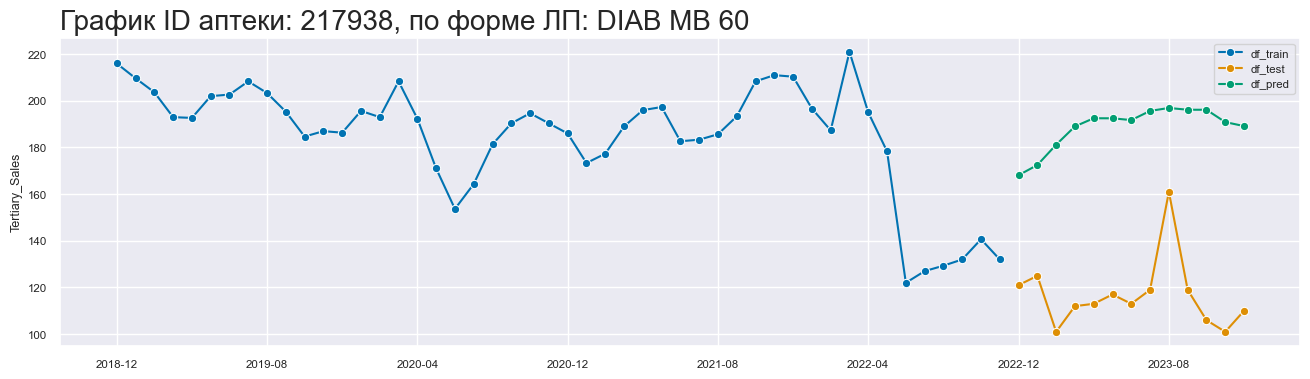

In [223]:
param_grid = {"window_length": [7, 12, 15], "estimator__n_neighbors": np.arange(1, 50)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(df_train) * 0.8), window_length=12)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(df_train)
df_pred = gscv.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

In [224]:
gscv.best_params_

{'estimator__n_neighbors': 14, 'window_length': 15}

0.6230622789371572

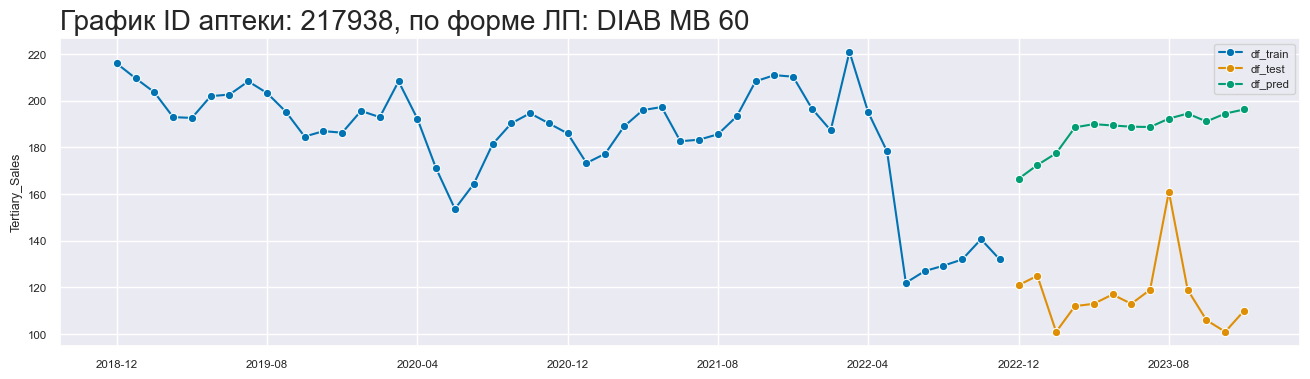

In [225]:
# настройка гиперпараметра 'n_estimator' для RandomForestRegressor из scikit-learn
regressor_param_grid = {"n_neighbors": np.arange(7, 9)}
forecaster_param_grid = {"window_length": [7,12, 15]}

# создайте настраиваемый регрессор с помощью GridSearchCV
regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(df_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(df_train)
df_pred = gscv.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

In [226]:
mse = MeanSquaredError()

param_grid = {"window_length": [7, 12, 15]}

regressor = KNeighborsRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(df_train) * 0.8), window_length=30)

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=mse)

gscv.fit(df_train)
gscv.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,1893.093410,0.029725,0.004916,{'window_length': 7},3.0
1,1752.867829,0.027107,0.005462,{'window_length': 12},1.0
2,1773.181282,0.026795,0.004957,{'window_length': 15},2.0


### 10 метод EnsembleForecaster

In [227]:
df_train1 = df.loc[(df['aptId_ru'] == apt_number) &(df['Name'] == lp_name)].Tertiary_Sales

0.09198783383495855

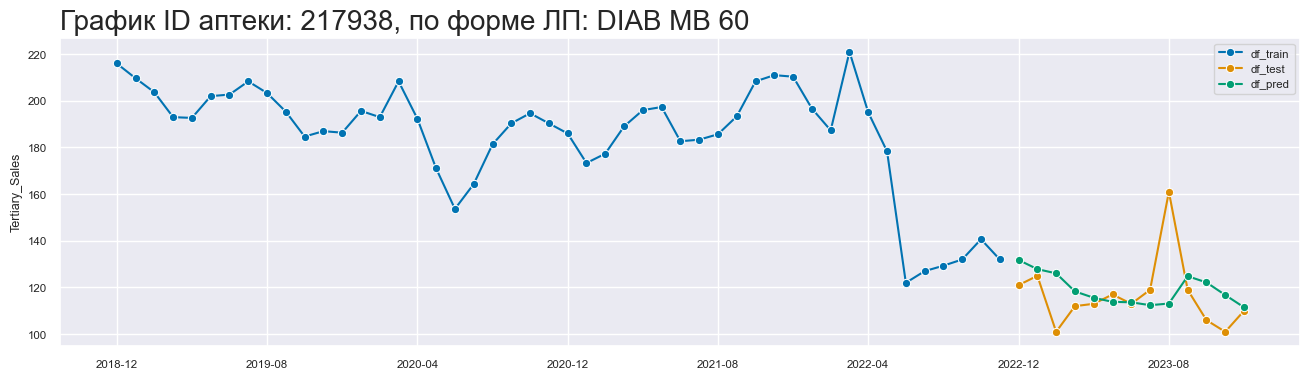

In [235]:
# 10 метод EnsembleForecaster
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=2)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=15)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ]
)
forecaster.fit(df_train1)
df_pred = forecaster.predict(fh_t)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

ValueError: Found input variables with inconsistent numbers of samples: [13, 3]

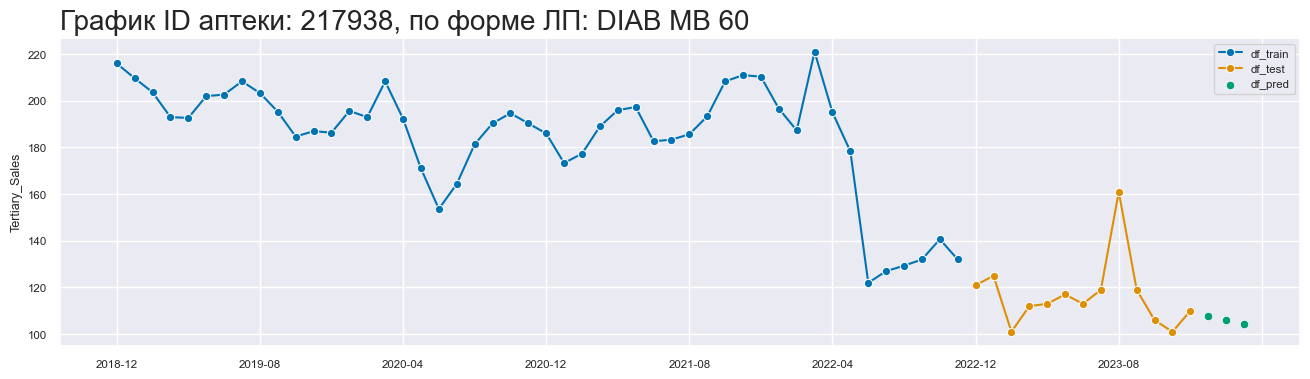

In [229]:
# 10 метод EnsembleForecaster
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=6)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y=df_train, fh=fh)
df_pred = forecaster.update_predict_single(df_test)
plot_series(df_train, df_test, df_pred, labels=["df_train", "df_test", "df_pred"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')
mean_absolute_percentage_error(df_test, df_pred, symmetric=False)

In [230]:
df_fact1 = df_fact.loc[(df_fact['aptId_ru'] == apt_number) &(df_fact['Name'] == lp_name)].Tertiary_Sales

In [231]:
df_fact1

period_ru
2024-01    104.0
2024-02    104.0
2024-03    116.0
Freq: M, Name: Tertiary_Sales, dtype: float64

In [232]:
df_pred

2024-01    107.891604
2024-02    106.174483
2024-03    104.458698
Freq: M, Name: Tertiary_Sales, dtype: float64

Text(0.0, 1.0, 'График ID аптеки: 217938, по форме ЛП: DIAB MB 60')

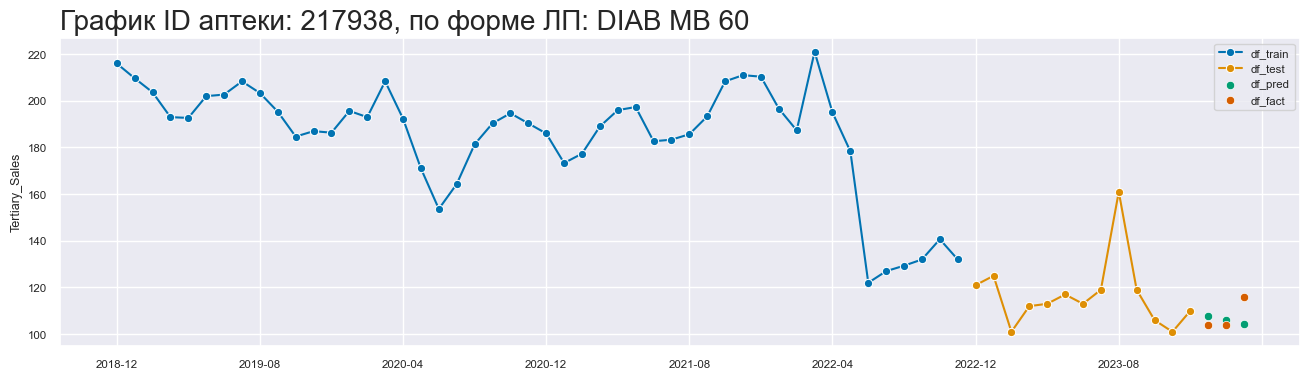

In [233]:
plot_series(df_train, df_test, df_pred, df_fact1, labels=["df_train", "df_test", "df_pred", "df_fact"])
plt.title('График ID аптеки: {}, по форме ЛП: {}'.format(apt_number, lp_name), fontsize= 20 , loc='left')